Task 1

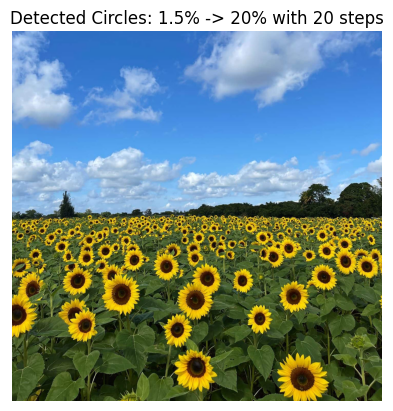

In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to compute percentage at each scale level
def percent_at_level(i, start_perc, end_perc, steps):
    step_size = (end_perc - start_perc) / (steps - 1)
    perc = (((i - 1) * step_size) / (end_perc - start_perc))**2 * (end_perc - start_perc) + start_perc
    return perc / 100

# Function to detect blobs using scale-space with Laplacian of Gaussian
def blob_detector(imname, start_perc, end_perc, steps):
    # Load and convert image to grayscale
    img = cv.imread(imname)
    img_float = img.astype(np.float32)
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    image_size = gray_image.shape
    scale_space = np.zeros((image_size[0], image_size[1], steps))
    max_results = np.zeros((image_size[0], image_size[1], steps))

    # Create the kernel
    sigma = 3
    kern_size = max(1, int(6 * sigma))
    kern = cv.getGaussianKernel(kern_size, sigma) - cv.getGaussianKernel(kern_size, sigma)[:, None]
    norm_kern = sigma ** 2 * kern

    # Apply the filter for each scale level
    for i in range(steps):
        scale_perc = percent_at_level(i, start_perc, end_perc, steps)
        new_image_size = int(image_size[1] * scale_perc)
        resized_img = cv.resize(gray_image, (new_image_size, new_image_size), interpolation=cv.INTER_LINEAR)
        filtered_img = cv.filter2D(resized_img, -1, norm_kern) ** 2
        filtered_img = cv.resize(filtered_img, (image_size[1], image_size[0]), interpolation=cv.INTER_LINEAR)
        scale_space[:, :, i] = filtered_img

    # 2D non-maximum suppression
    possible_max_list = []
    for i in range(steps):
        current_image = scale_space[:, :, i]
        threshold = 1000  # Fixed threshold
        mask_size = 5
        mx = cv.dilate(current_image, np.ones((mask_size, mask_size)))
        max_results[:, :, i] = (current_image == mx) & (current_image > threshold)
        r, c = np.where(max_results[:, :, i])
        possible_max_list.append((r, c))

    # 3D non-maximum suppression
    max_x = []
    max_y = []
    max_r = []
    for level in range(1, steps - 1):
        current_max = possible_max_list[level]
        current_radius = int(image_size[1] * percent_at_level(level, start_perc, end_perc, steps) * 0.4)
        for x, y in zip(current_max[0], current_max[1]):
            if x <= 5 or x >= image_size[0] - 5 or y <= 5 or y >= image_size[1] - 5:
                continue

            local_max = scale_space[x, y, level]
            upper_max = np.max(scale_space[x-5:x+6, y-5:y+6, level + 1])
            lower_max = np.max(scale_space[x-5:x+6, y-5:y+6, level - 1])
            if local_max > upper_max and local_max > lower_max:
                max_x.append(x)
                max_y.append(y)
                max_r.append(current_radius)

    # Plot detected circles
    fig, ax = plt.subplots()
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    for i in range(len(max_x)):
        circle = plt.Circle((max_y[i], max_x[i]), max_r[i], color='g', fill=False, linewidth=1.5)
        ax.add_patch(circle)
    ax.set_title(f"Detected Circles: {start_perc}% -> {end_perc}% with {steps} steps")
    plt.axis('off')
    plt.show()

# Sample call: 'sunflower_image.jpg' should be your input image
blob_detector('Img/the_berry_farms_sunflower_field.jpeg', 1.5, 20, 20)


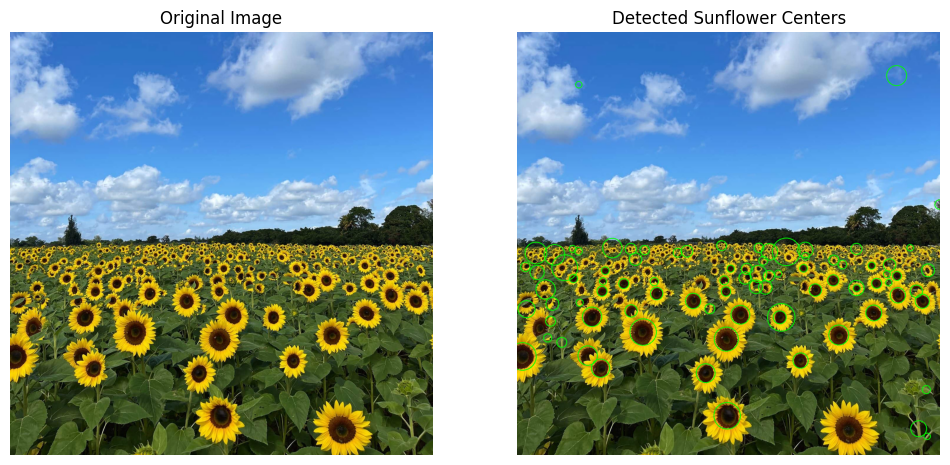

Detected circles (x, y, radius):
Center: (18, 1104), Radius: 47
Center: (1379, 916), Radius: 24
Center: (1296, 896), Radius: 26
Center: (1359, 882), Radius: 21
Center: (1265, 853), Radius: 11
Center: (1224, 855), Radius: 17
Center: (1293, 830), Radius: 15
Center: (1259, 824), Radius: 12
Center: (1207, 795), Radius: 12
Center: (1268, 793), Radius: 21
Center: (1396, 1376), Radius: 11
Center: (1367, 1350), Radius: 27
Center: (715, 1306), Radius: 45
Center: (1393, 1217), Radius: 14
Center: (642, 1161), Radius: 32
Center: (965, 1118), Radius: 26
Center: (284, 1144), Radius: 31
Center: (240, 1101), Radius: 33
Center: (152, 1056), Radius: 17
Center: (104, 1041), Radius: 14
Center: (1095, 1031), Radius: 34
Center: (114, 984), Radius: 17
Center: (32, 943), Radius: 29
Center: (656, 942), Radius: 17
Center: (899, 971), Radius: 47
Center: (894, 971), Radius: 22
Center: (213, 921), Radius: 12
Center: (1214, 956), Radius: 27
Center: (120, 925), Radius: 22
Center: (712, 1045), Radius: 41
Center: (760

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'Img/the_berry_farms_sunflower_field.jpeg'  # Update path if needed
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Check if image is loaded
if image is None:
    print("Error: Image not found or path is incorrect.")
else:
    # Convert to grayscale for processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Apply Gaussian Blur to reduce noise and improve blob detection
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Step 2: Enhance contrast with Histogram Equalization
    equalized = cv2.equalizeHist(blurred)

    # Step 3: Apply Otsu's thresholding to create a binary mask
    _, binary = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 4: Find contours (potential circles)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Draw detected contours
    output_image = image.copy()
    largest_circles = []

    for contour in contours:
        # Fit a minimum enclosing circle to each contour
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Filter based on size to ignore small or excessively large areas
        if 10 < radius < 50:  # Adjust this range based on your image's sunflower size
            # Store the largest circles
            largest_circles.append((center, radius))
            cv2.circle(output_image, center, radius, (0, 255, 0), 2)

    # Step 6: Display the results
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_image_rgb)
    plt.title('Detected Sunflower Centers')
    plt.axis('off')

    plt.show()

    # Report parameters of the largest circles
    print("Detected circles (x, y, radius):")
    for circle in largest_circles:
        center, radius = circle
        print(f"Center: {center}, Radius: {radius}")
